## Выявление спам сообщений среди комментариев с Youtube ## 

### Импорт библиотек

In [70]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('Set2')
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from scipy.sparse import csr_matrix

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import nltk
from nltk.tokenize import word_tokenize
import re
from gensim.models import Word2Vec
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

### Подготовка датасета

In [71]:
df = pd.read_csv('Youtube-Spam-Dataset.csv')
df.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,VIDEO_NAME,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",PSY - GANGNAM STYLE(?????) M/V,1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,PSY - GANGNAM STYLE(?????) M/V,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,PSY - GANGNAM STYLE(?????) M/V,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,PSY - GANGNAM STYLE(?????) M/V,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,PSY - GANGNAM STYLE(?????) M/V,1


In [72]:
df.sample(n=4)

,COMMENT_ID,AUTHOR,DATE,CONTENT,VIDEO_NAME,CLASS
928,z12lgxdibmu3vd0tt23nh3k4gkathp1mj,Nana Diaz,2015-04-26T20:44:52.830000,Check out this video on YouTube:﻿,"LMFAO - Party Rock Anthem ft. Lauren Bennett, ...",1
1037,z12bvjiqdvbrfzk1s23odzs53wjphzacf,‫مريم الهندي‬‎,2015-01-10T22:00:55.762000,Check out this video on YouTube:﻿,"LMFAO - Party Rock Anthem ft. Lauren Bennett, ...",1
596,z12gsvozdnffulgly23tdzyholacht41h,nleeklee polowtehow,2014-10-24T01:21:49,she is a fool. this is a foolish video. the ly...,Katy Perry - Roar,0
15,z13phrmwrkfisn5er22eyrbpbvaiwfvwf04,Gaming and Stuff PRO,2013-11-28T21:14:13,"Hello! Do you like gaming, art videos, scienti...",PSY - GANGNAM STYLE(?????) M/V,1


In [73]:
df.isnull().sum()

COMMENT_ID      0
AUTHOR          0
DATE          245
CONTENT         0
VIDEO_NAME      0
CLASS           0
dtype: int64

In [74]:
df_c = df.drop(['COMMENT_ID', 'DATE'], axis = 1)

In [75]:
df_c.tail()

,AUTHOR,CONTENT,VIDEO_NAME,CLASS
1951,Katie Mettam,I love this song because we sing it at Camp al...,Shakira - Waka Waka,0
1952,Sabina Pearson-Smith,I love this song for two reasons: 1.it is abou...,Shakira - Waka Waka,0
1953,jeffrey jules,wow,Shakira - Waka Waka,0
1954,Aishlin Maciel,Shakira u are so wiredo,Shakira - Waka Waka,0
1955,Latin Bosch,Shakira is the best dancer,Shakira - Waka Waka,0


#### Проверка на наличие пустых значений

In [76]:
df_c.isnull().sum()

AUTHOR        0
CONTENT       0
VIDEO_NAME    0
CLASS         0
dtype: int64

### Общие характеристики датасета

In [77]:
df_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1956 entries, 0 to 1955
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   AUTHOR      1956 non-null   object
 1   CONTENT     1956 non-null   object
 2   VIDEO_NAME  1956 non-null   object
 3   CLASS       1956 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 61.3+ KB


In [78]:
df_c.describe()

,CLASS
count,1956.000000
mean,0.513804
std,0.499937
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


#### Количество комментариев по авторам

In [79]:
author_counts = df_c.groupby('AUTHOR').size().reset_index(name='comment_count')
author_counts = author_counts.sort_values(by='comment_count', ascending=False)
author_counts.head()

,AUTHOR,comment_count
816,M.E.S,8
1159,Shadrach Grentz,7
10,5000palo,7
802,Louis Bryant,7
323,DanteBTV,6


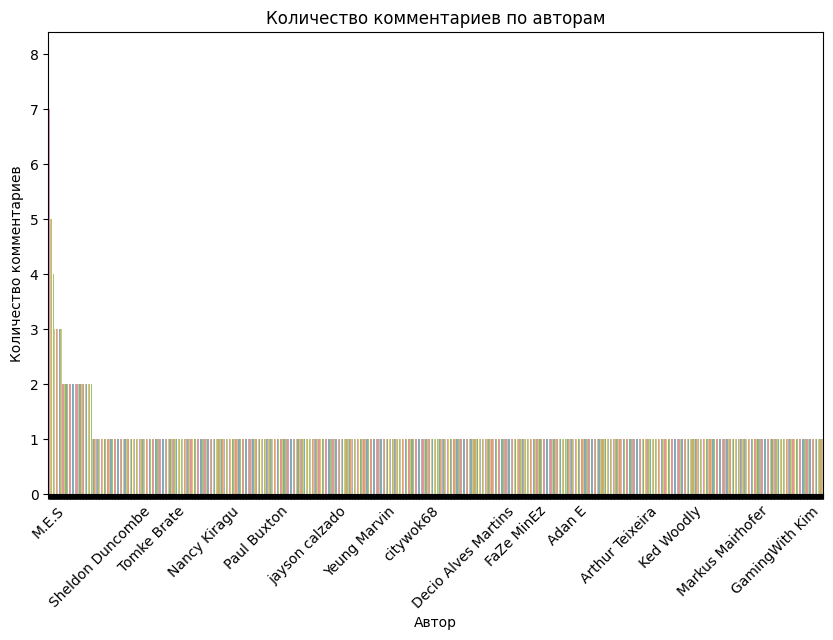

In [17]:
# Построение графика
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='AUTHOR', y='comment_count', data=author_counts, palette='Set2')

# Установка меток на оси X
xticks = author_counts['AUTHOR'].tolist()
ax.set_xticks(range(len(xticks)))  # Устанавливаем позиции меток
ax.set_xticklabels(xticks, rotation=45)  # Устанавливаем метки и поворачиваем их

# Скрытие некоторых меток
for i, label in enumerate(ax.get_xticklabels()):
    if i % 120 != 0:  # Показываем только метки делящиеся без остатка на 120
        label.set_visible(False)

plt.title('Количество комментариев по авторам')
plt.xlabel('Автор')
plt.ylabel('Количество комментариев')
plt.show()

<Figure size 1000x600 with 0 Axes>

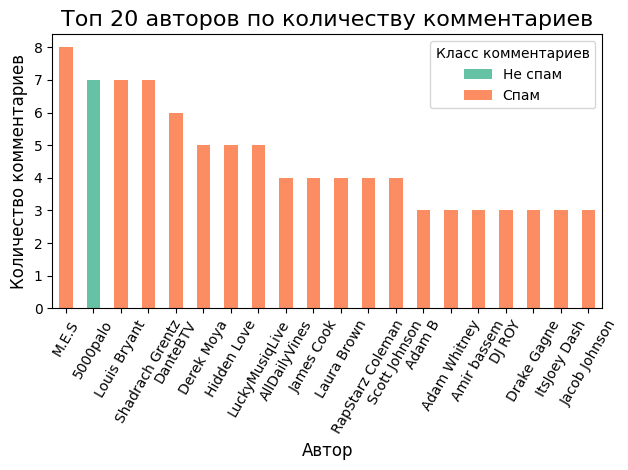

In [80]:
author_class_counts = df_c.groupby(['AUTHOR', 'CLASS']).size().unstack(fill_value=0)

# Get the top 10 authors
top_authors = author_class_counts.sum(axis=1).nlargest(20).index
top_authors_counts = author_class_counts.loc[top_authors]

# Plotting
plt.figure(figsize=(10, 6))
top_authors_counts.plot(kind='bar', stacked=True)

plt.title('Топ 20 авторов по количеству комментариев', fontsize=16)
plt.xlabel('Автор', fontsize=12)
plt.ylabel('Количество комментариев', fontsize=12)
plt.xticks(rotation=60)
plt.legend(title='Класс комментариев', labels=['Не спам', 'Спам'])
plt.tight_layout()
plt.show()

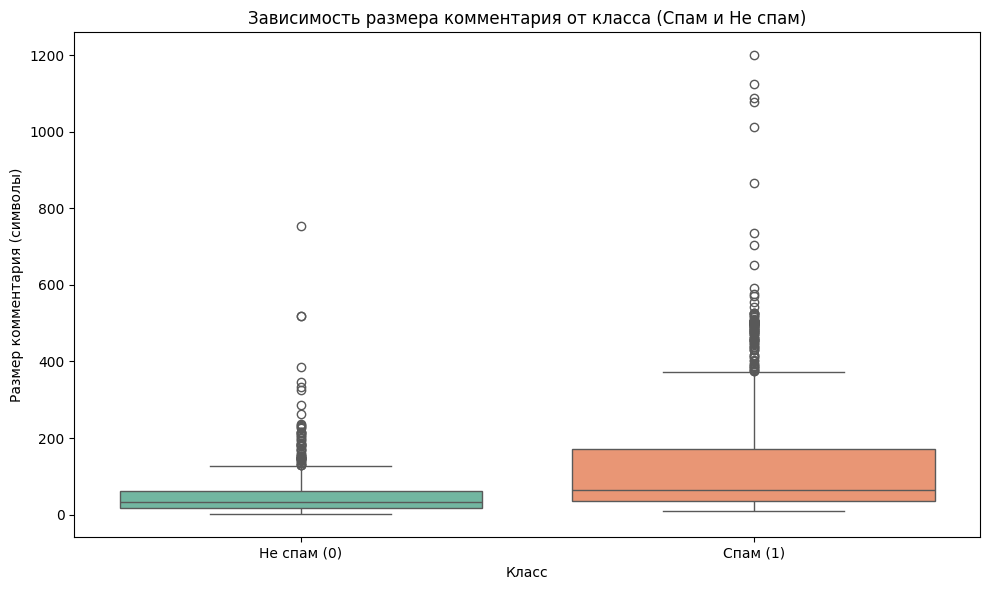

In [81]:
df_c['LENGTH'] = df_c['CONTENT'].apply(len)

# Построение графика зависимости размера комментария от класса
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_c, x='CLASS', y='LENGTH', palette='Set2')
plt.title('Зависимость размера комментария от класса (Спам и Не спам)')
plt.xlabel('Класс')
plt.ylabel('Размер комментария (символы)')
plt.xticks(ticks=[0, 1], labels=['Не спам (0)', 'Спам (1)'])
plt.tight_layout()
plt.show()

In [82]:
video_counts = df_c.groupby('VIDEO_NAME').size().reset_index(name='comment_count')
video_counts = video_counts.sort_values(by='comment_count', ascending=False)
video_counts

,VIDEO_NAME,comment_count
0,Eminem - Love The Way You Lie ft. Rihanna,448
2,"LMFAO - Party Rock Anthem ft. Lauren Bennett, ...",438
4,Shakira - Waka Waka,370
1,Katy Perry - Roar,350
3,PSY - GANGNAM STYLE(?????) M/V,350


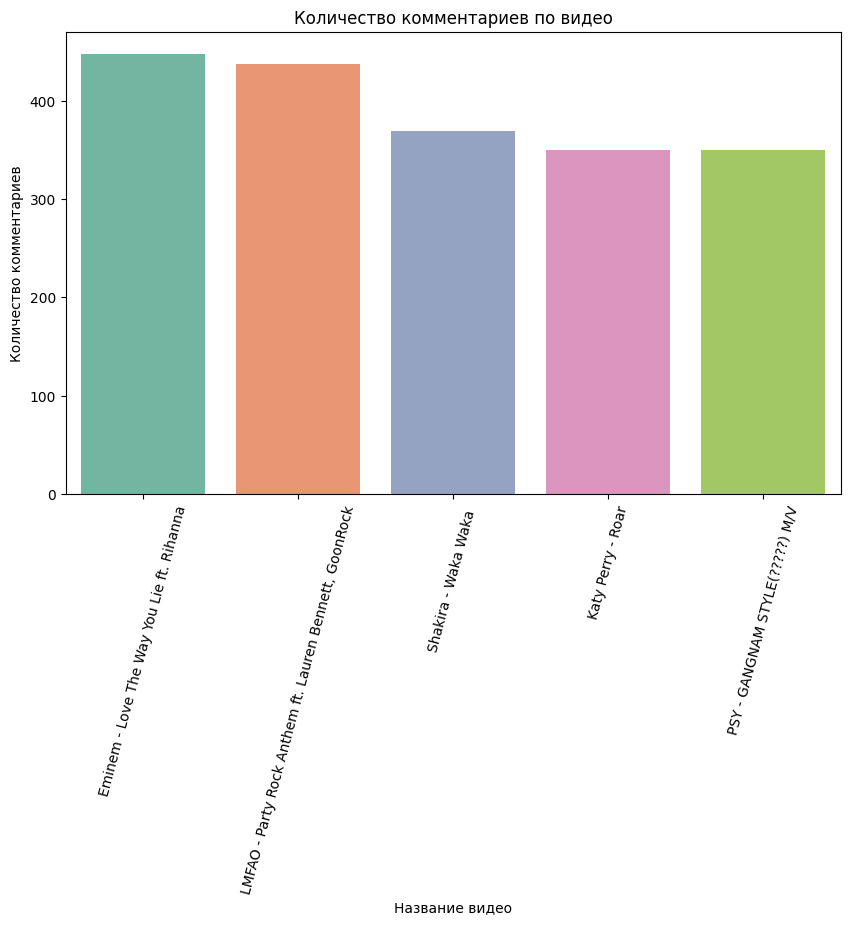

In [83]:
plt.figure(figsize=(10, 6))
sns.barplot(x='VIDEO_NAME', y='comment_count', data=video_counts, palette='Set2')
plt.title('Количество комментариев по видео')
plt.xlabel('Название видео')
plt.ylabel('Количество комментариев')
plt.xticks(rotation=75)
plt.show()

In [84]:
video_counts_spam = df_c.groupby(['VIDEO_NAME', 'CLASS']).size().reset_index(name='comment_count')
video_counts_spam = video_counts_spam.sort_values(by='comment_count', ascending=False)
video_counts_spam

,VIDEO_NAME,CLASS,comment_count
1,Eminem - Love The Way You Lie ft. Rihanna,1,245
5,"LMFAO - Party Rock Anthem ft. Lauren Bennett, ...",1,236
0,Eminem - Love The Way You Lie ft. Rihanna,0,203
4,"LMFAO - Party Rock Anthem ft. Lauren Bennett, ...",0,202
8,Shakira - Waka Waka,0,196
2,Katy Perry - Roar,0,175
3,Katy Perry - Roar,1,175
6,PSY - GANGNAM STYLE(?????) M/V,0,175
7,PSY - GANGNAM STYLE(?????) M/V,1,175
9,Shakira - Waka Waka,1,174


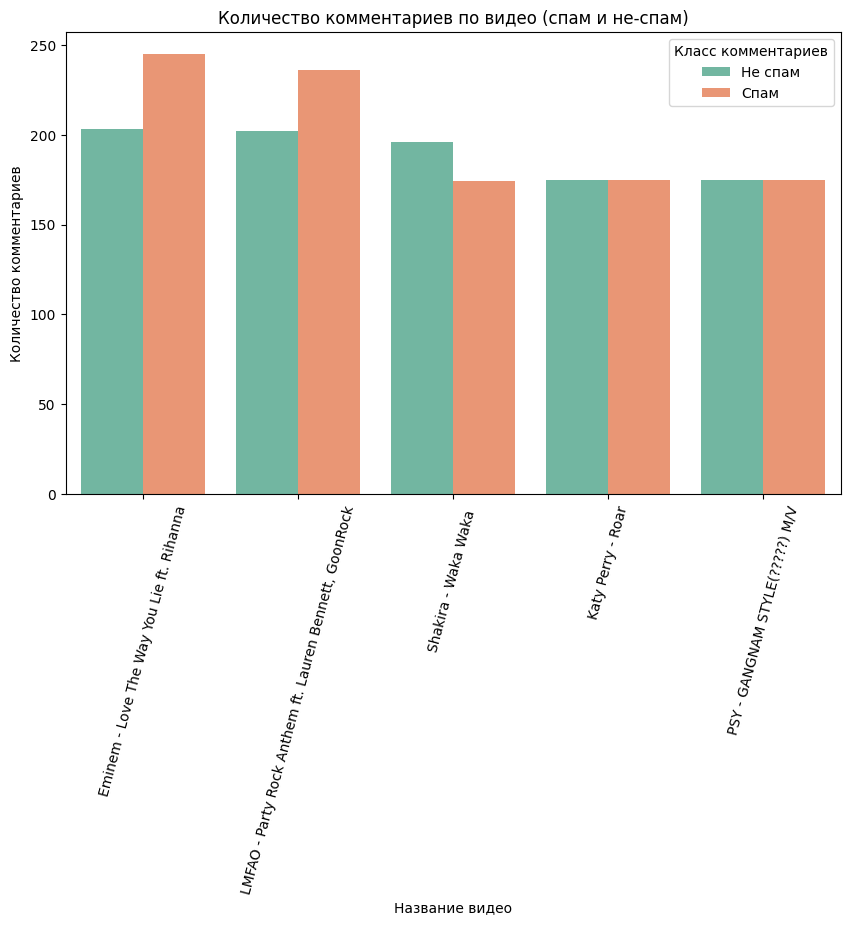

In [85]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='VIDEO_NAME', y='comment_count', hue='CLASS', data=video_counts_spam, palette='Set2')
plt.title('Количество комментариев по видео (спам и не-спам)')
plt.xlabel('Название видео')
plt.ylabel('Количество комментариев')
plt.xticks(rotation=75)  # Наклон меток по оси X
# Настройка легенды
handles, labels = ax.get_legend_handles_labels()
# Создание новой легенды с цветами колонок
ax.legend(handles, ['Не спам', 'Спам'], title='Класс комментариев')
plt.show()

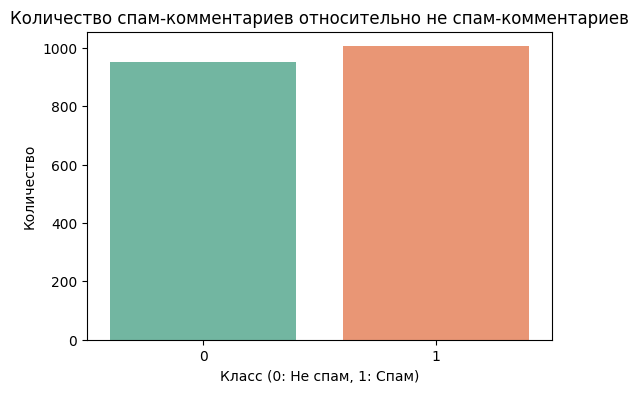

In [86]:
plt.figure(figsize=(6,4))
sns.countplot(x='CLASS', data=df_c, palette='Set2')
plt.title('Количество спам-комментариев относительно не спам-комментариев')
plt.xlabel('Класс (0: Не спам, 1: Спам)')
plt.ylabel('Количество')
plt.show()

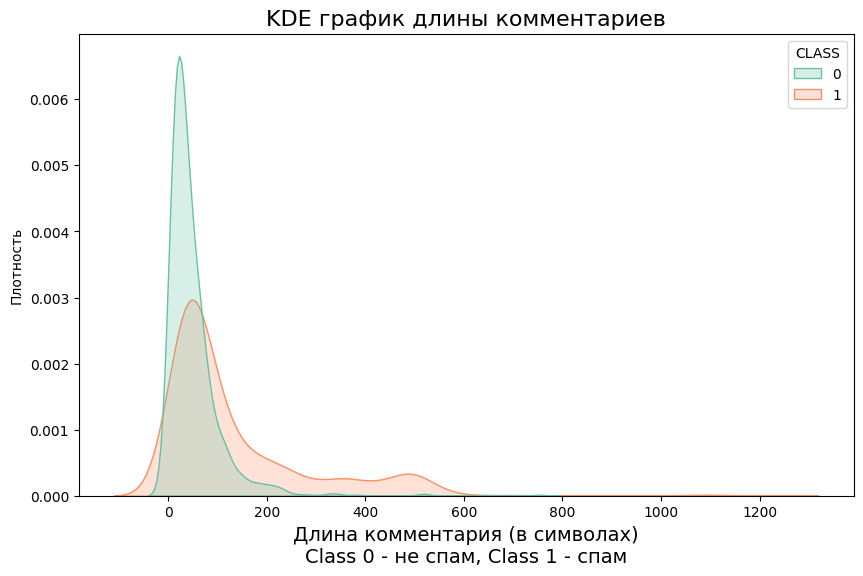

In [87]:
df_c['Comment Length'] = df_c['CONTENT'].apply(len)

plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_c, x='Comment Length', hue='CLASS', fill=True)
plt.title('KDE график длины комментариев', fontsize=16)
plt.xlabel('Длина комментария (в символах)\nClass 0 - не спам, Class 1 - спам', fontsize=14)
plt.ylabel('Плотность')
plt.show()

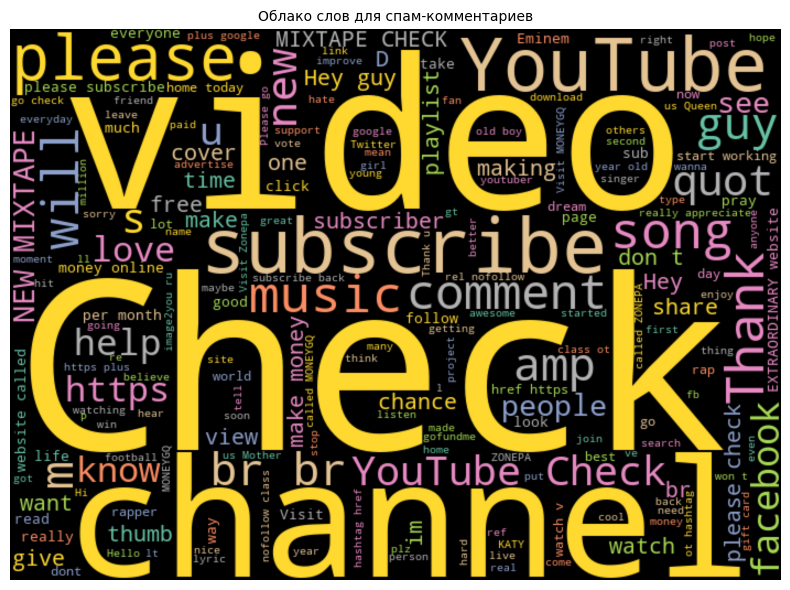

In [32]:
sp_comm = ' '.join(df_c[df_c['CLASS'] == 1]['CONTENT'])
sp_wc = WordCloud(width=700, height=500, colormap='Set2').generate(sp_comm)

plt.figure(figsize=(10, 6))
plt.imshow(sp_wc, interpolation='gaussian')
plt.axis('off')
plt.title('Облако слов для спам-комментариев', fontsize=10)
plt.tight_layout()
plt.show()

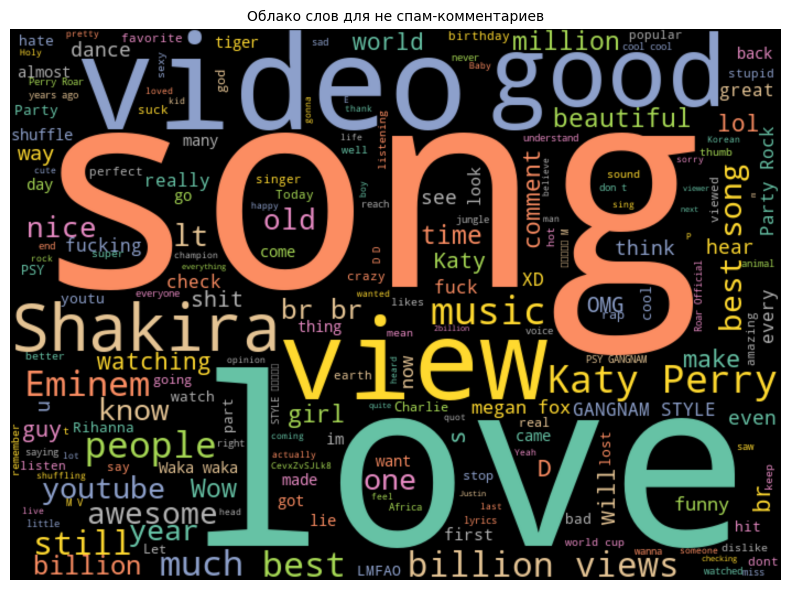

In [33]:
sp_comm = ' '.join(df_c[df_c['CLASS'] == 0]['CONTENT'])
sp_wc = WordCloud(width=700, height=500, colormap='Set2').generate(sp_comm)

plt.figure(figsize=(10, 6))
plt.imshow(sp_wc, interpolation='gaussian')
plt.axis('off')
plt.title('Облако слов для не спам-комментариев', fontsize=10)
plt.tight_layout()
plt.show()

In [34]:
# Преобразование'DATE' в datetime
df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')
df['YEAR'] = df['DATE'].dt.year
df['MONTH'] = df['DATE'].dt.month
df['DAY'] = df['DATE'].dt.day
df['HOUR'] = df['DATE'].dt.hour

In [35]:
correlation_matrix = df[['CLASS', 'YEAR', 'MONTH', 'DAY', 'HOUR']].corr()
print(correlation_matrix)

          CLASS      YEAR     MONTH       DAY      HOUR
CLASS  1.000000 -0.093763 -0.060805  0.014570  0.046772
YEAR  -0.093763  1.000000 -0.242577 -0.242398  0.019232
MONTH -0.060805 -0.242577  1.000000 -0.368434  0.005162
DAY    0.014570 -0.242398 -0.368434  1.000000 -0.006985
HOUR   0.046772  0.019232  0.005162 -0.006985  1.000000


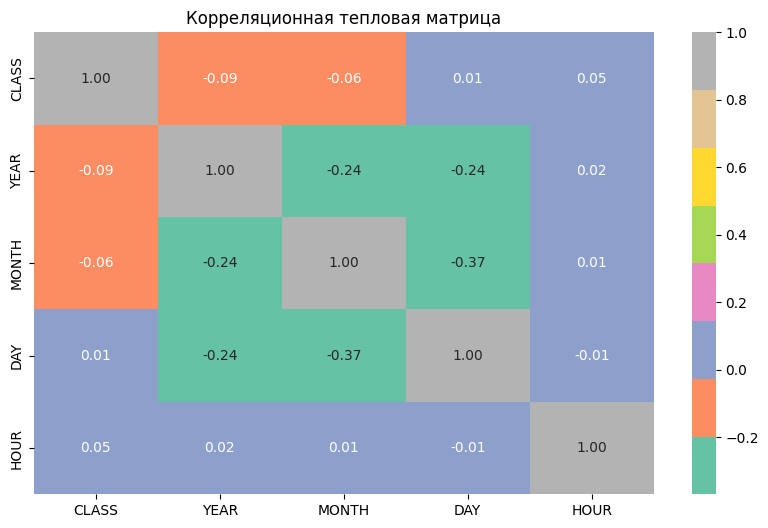

In [36]:
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Set2', fmt=".2f")
plt.title('Корреляционная тепловая матрица')
plt.show()

### Предварительные выводы

##### При сравнительно одинаковых выбросах спам-комментарии имеют в целом большую длину, чем не спам. Самые длинные комментарии почти всегда относятся к категории спама. С другой стороны, большая часть наиболее часто комментирующих авторов являются спаммерами. Кроме того спам комментарии в целом имеют меньшую палитру эмоций, носят более инструментальный, общий и зазывный характер (чаще используются слова "please", "check", "channel", "youtube" и т.д.), тогда как не спам комментарии имеют большую палитру эмоций, носят скорее оценочный характер и больше стремятся описывать видео, чем призывать к действиям (чаще используются слова "love", "song", "Shakira", "good" и т.д.). 

##### Таким образом, чаще пишущие люди, как правило, могут быть отнесены к спаммерам, нетипично большие комментарии также могут быть отнесены к спаму. Более того, семантические характеристики комментариев также могут позволить отличить спам комментарии от обычных. 

##### На основе сделанных выводов можно предложить использование следующих моделей для выявления спам-сообщений в данном дата-сете:

#### Логистическая регрессия
##### Логистическая регрессия — это простой и эффективный метод для бинарной классификации. Она может быть использована для определения вероятности того, что комментарий является спамом, основываясь на различных признаках, таких как длина комментария, частота использования определённых слов и эмоциональная окраска.
#### Деревья решений
##### Деревья решений позволяют визуализировать процесс принятия решений и могут быть полезны для интерпретации результатов. Они могут учитывать множество признаков, таких как длина комментария, частота определённых слов и эмоциональная окраска.
#### Метод опорных векторов (SVM)
##### Метод опорных векторов могут быть эффективны для задач классификации, особенно когда данные имеют высокую размерность. SVM может быть использован для нахождения оптимальной гиперплоскости, разделяющей спам и не спам комментарии.
#### Naive Bayes
##### Модель Наивного Байеса может быть использована для классификации текста на основе вероятностного подхода. Она хорошо работает с текстовыми данными и может быть быстрой в обучении и предсказании.
#### Глубокое обучение
##### Нейронные сети являются мощным инструментом для классификации текстовых данных. Они способны выявлять сложные закономерности и взаимосвязи в больших объемах текстовой информации. 

### Логистическая регрессия

In [88]:
# Векторизация контента с использованием TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
X = tfidf.fit_transform(df_c['CONTENT'])
y = df_c['CLASS']

In [89]:
# Разделение данных на тестовые и тренировочные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [90]:
# Тренируем модель
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [91]:
# Предсказание тестового сета
y_pred = model.predict(X_test)

In [92]:
# Расчитываем точность
accuracy_log_reg1 = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy_log_reg1:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.93
              precision    recall  f1-score   support

           0       0.89      0.97      0.92       176
           1       0.97      0.90      0.93       216

    accuracy                           0.93       392
   macro avg       0.93      0.93      0.93       392
weighted avg       0.93      0.93      0.93       392



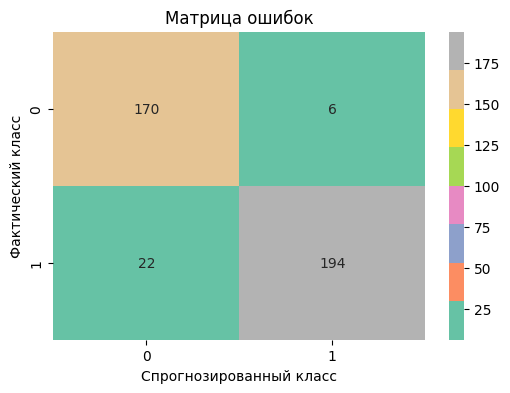

In [93]:
# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Set2')
plt.title('Матрица ошибок')
plt.xlabel('Спрогнозированный класс')
plt.ylabel('Фактический класс')
plt.show()

#### Попробуем включить в изначальную матрицу данные о длине и частоте комментариев

In [94]:
video_counts = df.groupby('VIDEO_NAME').size().reset_index(name='comment_count')

# Объединение данных
df_m = df_c.merge(video_counts, on='VIDEO_NAME', how='left')

In [95]:
# Векторизация 'CONTENT'
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
X_content = tfidf.fit_transform(df['CONTENT'])

# Преобразование 'comment_count' и 'Comment Length' в массив
X_count = df_m['comment_count'].values.reshape(-1, 1)
X_length = df_m['Comment Length'].values.reshape(-1, 1)

# Преобразование X_count и X_length в разреженную матрицу

X_count_sparse = csr_matrix(X_count)
X_count_sparse2 = csr_matrix(X_length)

# Объединение признаков
X = hstack([X_content, X_count_sparse, X_count_sparse2])
y = df_m['CLASS']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели логистической регрессии
model = LogisticRegression()
model.fit(X_train, y_train)

# Прогнозирование на тестовой выборке
y_pred = model.predict(X_test)

# Оценка модели
accuracy_log_reg2 = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy_log_reg2:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.94
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       176
           1       0.97      0.91      0.94       216

    accuracy                           0.94       392
   macro avg       0.93      0.94      0.94       392
weighted avg       0.94      0.94      0.94       392



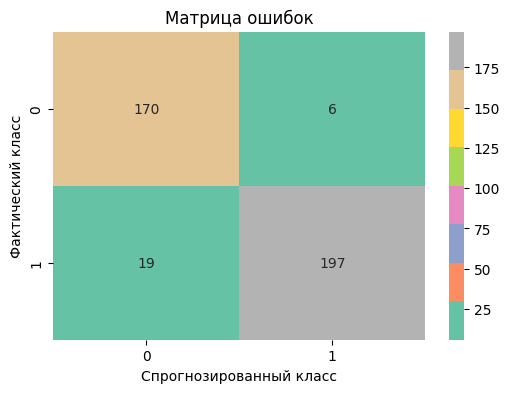

In [96]:
# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Set2')
plt.title('Матрица ошибок')
plt.xlabel('Спрогнозированный класс')
plt.ylabel('Фактический класс')
plt.show()

### Дерево решений

In [97]:
# Разделение данных на признаки и целевую переменную
X = df_c['CONTENT']
y = df_c['CLASS']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [98]:
# Преобразование текстов в числовые векторы
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [99]:
# Создание и обучение модели
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train_vectorized, y_train)

DecisionTreeClassifier(random_state=42)

In [100]:
# Прогнозирование на тестовой выборке
y_pred = model.predict(X_test_vectorized)

# Оценка модели
accuracy_forest1 = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy_forest1:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.93
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       176
           1       0.94      0.94      0.94       216

    accuracy                           0.93       392
   macro avg       0.93      0.93      0.93       392
weighted avg       0.93      0.93      0.93       392



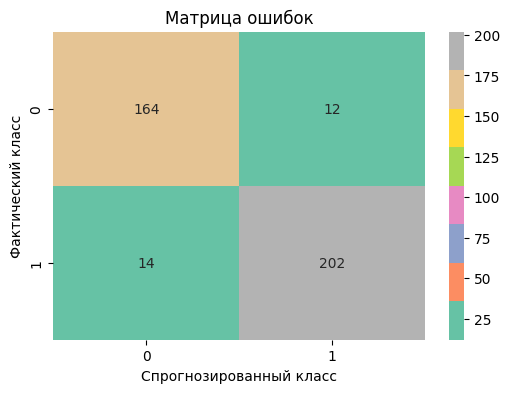

In [101]:
# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Set2')
plt.title('Матрица ошибок')
plt.xlabel('Спрогнозированный класс')
plt.ylabel('Фактический класс')
plt.show()

#### Попробуем включить в изначальную матрицу данные о длине и частоте комментариев

In [102]:
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
X_content = tfidf.fit_transform(df['CONTENT'])

# Преобразование 'comment_count' и 'Comment Length' в массив
X_count = df_m['comment_count'].values.reshape(-1, 1)
X_length = df_m['Comment Length'].values.reshape(-1, 1)

# Преобразование X_count и X_length в разреженную матрицу

X_count_sparse = csr_matrix(X_count)
X_count_sparse2 = csr_matrix(X_length)

# Объединение признаков
X = hstack([X_content, X_count_sparse, X_count_sparse2])
y = df_m['CLASS']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [103]:
# Создание и обучение модели
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [104]:
# Прогнозирование на тестовой выборке
y_pred = model.predict(X_test)

# Оценка модели
accuracy_forest2 = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy_forest2:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.94
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       176
           1       0.94      0.94      0.94       216

    accuracy                           0.94       392
   macro avg       0.94      0.94      0.94       392
weighted avg       0.94      0.94      0.94       392



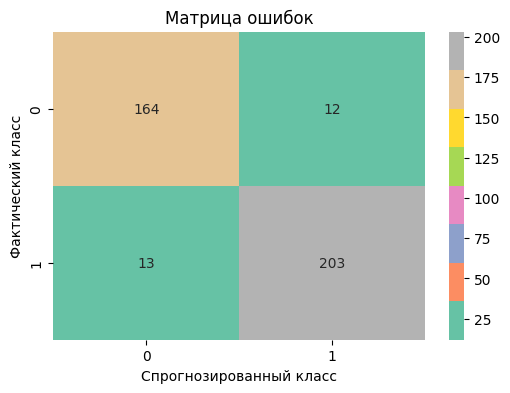

In [105]:
# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Set2')
plt.title('Матрица ошибок')
plt.xlabel('Спрогнозированный класс')
plt.ylabel('Фактический класс')
plt.show()

### Классификатор опорных векторов (SVC)

In [138]:
# Разделение данных на признаки и целевую переменную
X = df_c['CONTENT']
y = df_c['CLASS']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [139]:
# Преобразование текстов в числовые векторы
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [140]:
# Создание и обучение модели SVC
model = SVC(kernel='linear', random_state=42)
model.fit(X_train_vectorized, y_train)

SVC(kernel='linear', random_state=42)

In [141]:
# Прогнозирование на тестовой выборке
y_pred = model.predict(X_test_vectorized)

# Оценка модели
accuracy_svc1 = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy_svc1:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.95
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       176
           1       0.97      0.94      0.95       216

    accuracy                           0.95       392
   macro avg       0.95      0.95      0.95       392
weighted avg       0.95      0.95      0.95       392



In [110]:
message = "Buy my short! Follow the link below!"
new_message_vectorized = vectorizer.transform([message])

#### Тестируем модель

In [111]:
prediction = model.predict(new_message_vectorized)

In [112]:
if prediction == 1:
    print("Сообщение является спамом.")
else:
    print("Сообщение не является спамом.")

Сообщение является спамом.


#### Выгружаем модель в файл

In [113]:
with open('svc_model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [114]:
with open('vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

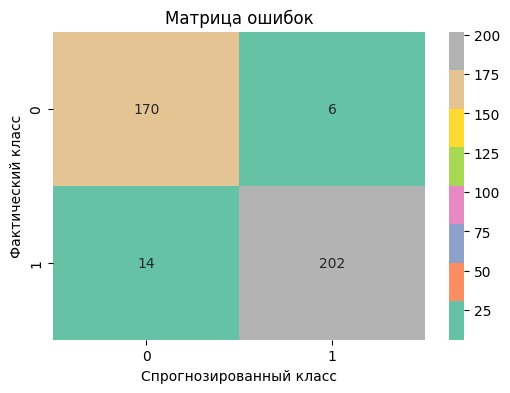

In [115]:
# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Set2')
plt.title('Матрица ошибок')
plt.xlabel('Спрогнозированный класс')
plt.ylabel('Фактический класс')
plt.show()

#### Попробуем включить в изначальную матрицу данные о длине и частоте комментариев

In [143]:
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
X_content = tfidf.fit_transform(df['CONTENT'])

# Преобразование 'comment_count' и 'Comment Length' в массив
X_count = df_m['comment_count'].values.reshape(-1, 1)
X_length = df_m['Comment Length'].values.reshape(-1, 1)

# Преобразование X_count и X_length в разреженную матрицу

X_count_sparse = csr_matrix(X_count)
X_count_sparse2 = csr_matrix(X_length)

# Объединение признаков
X = hstack([X_content, X_count_sparse, X_count_sparse2])
y = df_m['CLASS']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [144]:
# Создание и обучение модели SVC
model = SVC(kernel='linear', random_state=42)
model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [146]:
# Прогнозирование на тестовой выборке
y_pred = model.predict(X_test)

# Оценка модели
accuracy_svc2 = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy_svc2:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.95
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       176
           1       0.97      0.93      0.95       216

    accuracy                           0.95       392
   macro avg       0.94      0.95      0.95       392
weighted avg       0.95      0.95      0.95       392



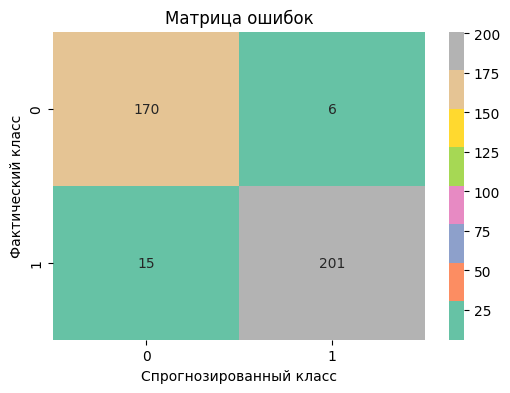

In [127]:
# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Set2')
plt.title('Матрица ошибок')
plt.xlabel('Спрогнозированный класс')
plt.ylabel('Фактический класс')
plt.show()

### Наивный Байес (MultinomialNB)

In [147]:
# Разделение данных на признаки и целевую переменную
X = df_c['CONTENT']
y = df_c['CLASS']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [148]:
# Преобразование текстов в числовые векторы
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [149]:
# Создание и обучение модели MultinomialNB
model = MultinomialNB()
model.fit(X_train_vectorized, y_train)

MultinomialNB()

In [150]:
# Прогнозирование на тестовой выборке
y_pred = model.predict(X_test_vectorized)

# Оценка модели
accuracy_mult1 = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy_mult1:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.93
              precision    recall  f1-score   support

           0       0.96      0.88      0.91       176
           1       0.90      0.97      0.94       216

    accuracy                           0.93       392
   macro avg       0.93      0.92      0.92       392
weighted avg       0.93      0.93      0.93       392



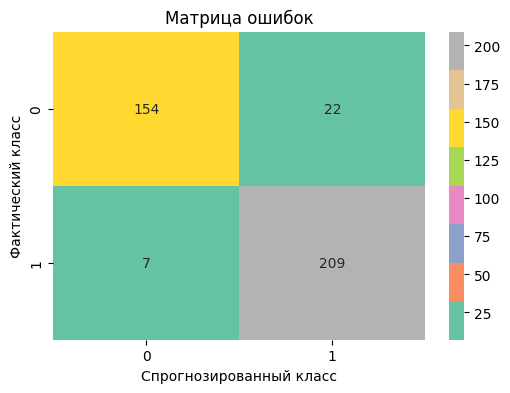

In [132]:
# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Set2')
plt.title('Матрица ошибок')
plt.xlabel('Спрогнозированный класс')
plt.ylabel('Фактический класс')
plt.show()

#### Попробуем включить в изначальную матрицу данные о длине и частоте комментариев

In [151]:
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
X_content = tfidf.fit_transform(df['CONTENT'])

# Преобразование 'comment_count' и 'Comment Length' в массив
X_count = df_m['comment_count'].values.reshape(-1, 1)
X_length = df_m['Comment Length'].values.reshape(-1, 1)

# Преобразование X_count и X_length в разреженную матрицу

X_count_sparse = csr_matrix(X_count)
X_count_sparse2 = csr_matrix(X_length)

# Объединение признаков
X = hstack([X_content, X_count_sparse, X_count_sparse2])
y = df_m['CLASS']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [152]:
# Создание и обучение модели MultinomialNB
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [153]:
# Прогнозирование на тестовой выборке
y_pred = model.predict(X_test)

# Оценка модели
accuracy_mult2 = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy_mult2:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.63
              precision    recall  f1-score   support

           0       0.56      0.86      0.68       176
           1       0.80      0.44      0.57       216

    accuracy                           0.63       392
   macro avg       0.68      0.65      0.62       392
weighted avg       0.69      0.63      0.62       392



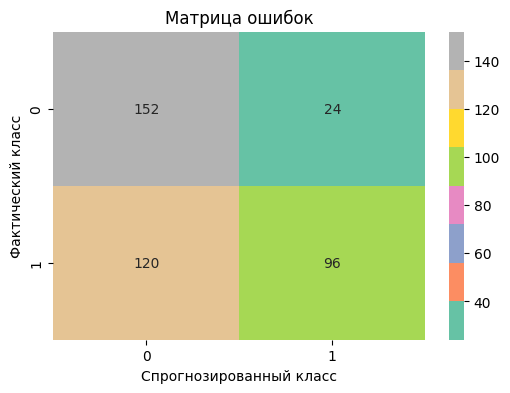

In [136]:
# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Set2')
plt.title('Матрица ошибок')
plt.xlabel('Спрогнозированный класс')
plt.ylabel('Фактический класс')
plt.show()

### Word to Vec

In [154]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\goodwin228\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [54]:
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'((www\.[^\s]+|(https?://[^\s]+)))', 'URL', text)
    text = re.sub(r'@[^\s]+', 'USER', text)
    text = re.sub(r'[^a-zA-Za-яА-Я1-9]+', ' ', text)
    text = re.sub(r' +', ' ', text)
    text = text.lower()  # Convert to lowercase
    return word_tokenize(text)

In [55]:
df_c['PROCESSED_CONTENT'] = df_c['CONTENT'].apply(preprocess_text)

X_train, X_test, y_train, y_test = train_test_split(df_c['PROCESSED_CONTENT'], df_c['CLASS'], test_size=0.2, random_state=42)

In [42]:
# модель Word2Vec
w2v_model = Word2Vec(sentences=X_train, vector_size=100, window=5, min_count=1, workers=4)

In [43]:
def vectorize_text(text):
    vectors = [w2v_model.wv[word] for word in text if word in w2v_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(w2v_model.vector_size)

X_train_vectors = np.array([vectorize_text(text) for text in X_train])
X_test_vectors = np.array([vectorize_text(text) for text in X_test])

In [195]:
# собираем и обучаем модель
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(w2v_model.vector_size,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_vectors, y_train, epochs=1000, batch_size=100, 
                    validation_split=0.2, 
                    callbacks=[EarlyStopping(monitor='accuracy', patience=100)], verbose=0)

In [196]:
wtw_loss, wtw_accuracy = model.evaluate(X_test_vectors, y_test)
print(f'Accuracy: {wtw_accuracy:.2f}')
print(f'Loss: {wtw_loss:.2f}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9106 - loss: 0.4982 
Accuracy: 0.90
Loss: 0.39


In [56]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       176
           1       0.97      0.91      0.94       216

    accuracy                           0.94       392
   macro avg       0.93      0.94      0.94       392
weighted avg       0.94      0.94      0.94       392



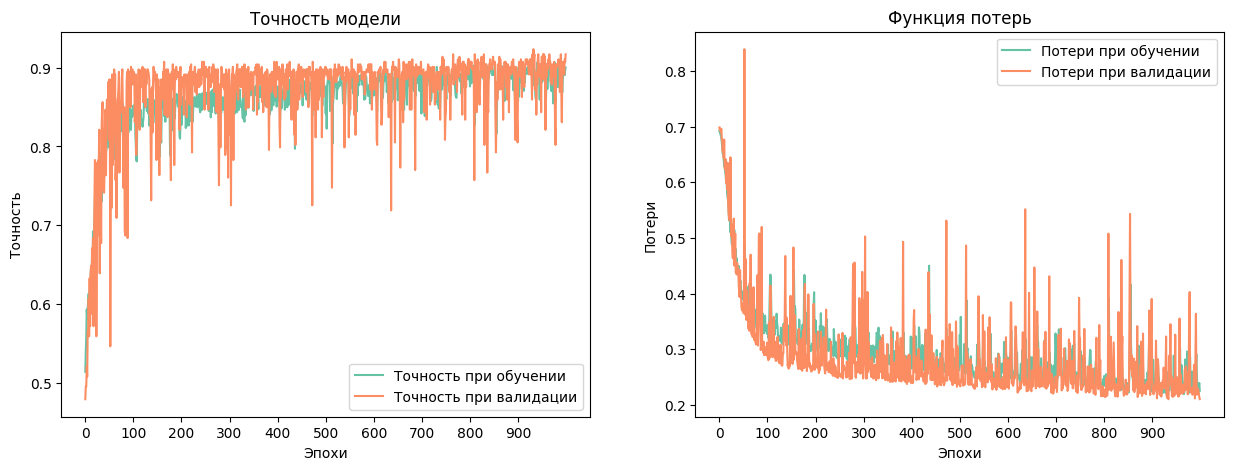

In [202]:
# Функция для построения графиков
def plot_model_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    # График точности
    axs[0].plot(history.history['accuracy'], label='Точность при обучении')
    axs[0].plot(history.history['val_accuracy'], label='Точность при валидации')
    axs[0].set_title('Точность модели')
    axs[0].set_ylabel('Точность')
    axs[0].set_xlabel('Эпохи')
    axs[0].set_xticks(np.arange(0, len(history.history['accuracy']), step=100))  # Устанавливаем шаг
    axs[0].legend(loc='best')
    
    # График потерь
    axs[1].plot(history.history['loss'], label='Потери при обучении')
    axs[1].plot(history.history['val_loss'], label='Потери при валидации')
    axs[1].set_title('Функция потерь')
    axs[1].set_ylabel('Потери')
    axs[1].set_xlabel('Эпохи')
    axs[1].set_xticks(np.arange(0, len(history.history['loss']), step=100))  # Устанавливаем шаг
    axs[1].legend(loc='best')
    
    plt.show()

# Вызов функции для построения графиков
plot_model_history(history)

#### Сравнительная таблица результатов точности моделей

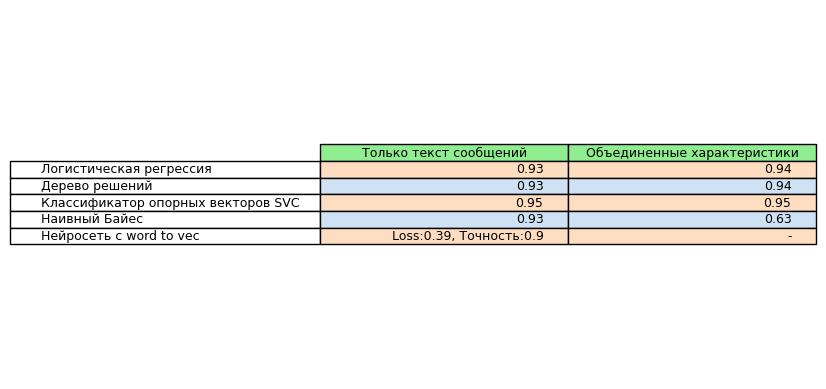

In [201]:
# Данные для таблицы
columns = ["Только текст сообщений", "Объединенные характеристики"]
rows = ["Логистическая регрессия", "Дерево решений", "Классификатор опорных векторов SVC", "Наивный Байес", "Нейросеть с word to vec"]
data = [
    [round(accuracy_log_reg1, 2), round(accuracy_log_reg2, 2)],  # Логистическая регрессия
    [round(accuracy_forest1, 2), round(accuracy_forest2, 2)],
    [round(accuracy_svc1, 2), round(accuracy_svc2, 2)],
    [round(accuracy_mult1, 2), round(accuracy_mult2, 2)],
    [f'Loss:{round(wtw_loss, 2)}, Точность:{round(wtw_accuracy, 2)}', "-"] # Наивный Байес
]

# Создание таблицы
fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=data, colLabels=columns, rowLabels=rows, loc='center')
# Настройка внешнего вида таблицы
table.auto_set_font_size(False)
table.set_fontsize(9)

# Раскраска заголовков в зеленый цвет
header_color = '#90EE90'  # Светло-зеленый цвет
for j in range(len(columns)):
    cell = table[(0, j)]  # Заголовки находятся в первой строке
    cell.set_facecolor(header_color)  # Применяем цвет к заголовкам

# Раскраска строк
colors = ['#FFDDC1', '#CFE2F3']  # Цвета для строк
for i, row in enumerate(data):
    for j in range(len(row)):
        cell = table[(i + 1, j)]  # +1, чтобы пропустить заголовок
        cell.set_facecolor(colors[i % len(colors)])  # Применяем цвет



# Показ таблицы
plt.show()